## Packages

In [16]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import csv
import random

## The dataset
The data set is taken from two Gaussian distributions.

In [17]:
mpl.rcParams['font.sans-serif'] = ['SimHei']
# 读取
with open("dataset.csv", "r") as f:
    reader = csv.DictReader(f)
    datas = [row for row in reader]
for data in datas:
    print(data)

{'x': '0.8273000035635103', 'y': '-0.6479480861007281', 'L': '1'}
{'x': '0.916333322834716', 'y': '0.2942142484232922', 'L': '1'}
{'x': '0.4455504113778963', 'y': '-0.5426942502756325', 'L': '1'}
{'x': '0.07108559257996117', 'y': '0.7342060455133328', 'L': '1'}
{'x': '0.4541183359619083', 'y': '0.5721048932887726', 'L': '1'}
{'x': '0.5962537842837075', 'y': '-0.17560010021719097', 'L': '1'}
{'x': '0.04360894698876683', 'y': '0.1773233399331685', 'L': '1'}
{'x': '0.9637653822149224', 'y': '0.19982647707373793', 'L': '1'}
{'x': '0.9083056213943264', 'y': '-0.6033741628118447', 'L': '1'}
{'x': '1.9822080099322918', 'y': '-0.3667918216336089', 'L': '1'}
{'x': '1.3049894630191854', 'y': '0.43001801887280905', 'L': '1'}
{'x': '-0.060267924742109846', 'y': '0.16071137671397492', 'L': '1'}
{'x': '-0.193798021121377', 'y': '-0.5100852638529891', 'L': '1'}
{'x': '1.932514417215768', 'y': '0.08930564211034907', 'L': '1'}
{'x': '1.3511826393322552', 'y': '-0.23996609293259227', 'L': '1'}
{'x': '0.

1000 samples

## The parameter

In [18]:
alpha_0 = 0.95
num_split = 10
K = range(2, 25)

## Compute the distance of two samples

In [19]:
def distance(d1, d2):
    res = 0
    for key in ("x", "y"):
        res += (float(d1[key])-float(d2[key]))**2
    return res**0.5

## Compute le phi for DS-Knn

In [20]:
def func1(d, gamma):
    return alpha_0 * exp(-gamma * d)

## Predict

In [21]:
def knn(data, n, set):
    # 1.距离
    res = [
        {"result": train['L'], "distance":distance(data, train)}
        for train in set
    ]
    # 2.升序排序
    res = sorted(res, key=lambda item: item['distance'])
    # 3.取前k个
    res2 = res[0:k]
    result = {"1": 0, "2": 0}

    if n == 2:  # 加权平均Knn
        a = res2[k-1]['distance'] - res2[0]['distance']
        for r in res2:
            result[r['result']] += (res2[k-1]['distance']-r['distance'])/a

    elif n == 1:  # Knn
        for r in res2:
            if r['result'] == '1':
                result['1'] += 1
            else:
                result['2'] += 1

    else:  # 结合DS理论后的Knn
        res3 = [
            {"result": r['result'], "alpha": r['distance']}
            for r in res2
        ]
        for r in res3:
            if r['result'] == '1':
                r['alpha'] = func1(r['alpha'], gamma_q_1)
            else:
                r['alpha'] = func1(r['alpha'], gamma_q_2)
        res_1 = []
        res_2 = []
        for r in res3:
            if r['result'] == '1':
                res_1.append(r)
            else:
                res_2.append(r)
        a_1 = 1
        a_2 = 1
        for r in res_1:
            a_1 = a_1 * (1 - r['alpha'])
        for r in res_2:
            a_2 = a_2 * (1 - r['alpha'])
        ka = a_1 + a_2 - a_1 * a_2
        m_1 = (1 - a_1) * a_2 / ka
        m_2 = (1 - a_2) * a_1 / ka
        m = 1 - m_1 - m_2
        if m_1 > m_2:
            result['1'] += 1
        else:
            result['2'] += 1

    if result['1'] > result['2']:
        return '1'
    else:
        return '2'

## X Cross-validation

In [22]:
rates_right_knn = []
rates_right_wknn = []
rates_right_dsknn = []
random.shuffle(datas)
datas1 = np.array_split(datas, num_split)
for k in K:
    rate_right_knn = 0
    rate_right_wknn = 0
    rate_right_dsknn = 0
    for i in range(num_split):
        train_set = datas1[i]
        train_set_1 = [
            {"x": r['x'], "y": r['y'], "L": r['L']}
            for r in train_set
            if r['L'] == '1'
        ]
        train_set_2 = [
            {"x": r['x'], "y": r['y'], "L": r['L']}
            for r in train_set
            if r['L'] == '2'
        ]
        dist1 = 0
        for d1 in train_set_1:
            for d2 in train_set_1:
                dist1 += distance(d1, d2)
        gamma_q_1 = (len(train_set_1) - 1) * len(train_set_1) / dist1
        dist2 = 0
        for d1 in train_set_2:
            for d2 in train_set_2:
                dist2 += distance(d1, d2)
        gamma_q_2 = (len(train_set_2) - 1) * len(train_set_2) / dist2
        test_set = np.concatenate(datas1[:i] + datas1[i + 1:])
        correct_knn = 0
        correct_wknn = 0
        correct_dsknn = 0
        for test in test_set:
            result = test['L']
            result_knn = knn(test, 1, train_set)
            result_wknn = knn(test, 2, train_set)
            result_dsknn = knn(test, 3, train_set)
            if result == result_knn:
                correct_knn += 1
            if result == result_wknn:
                correct_wknn += 1
            if result == result_dsknn:
                correct_dsknn += 1
        rate_right_knn += 100 * correct_knn / len(test_set)
        rate_right_wknn += 100 * correct_wknn / len(test_set)
        rate_right_dsknn += 100 * correct_dsknn / len(test_set)

    rate_right_knn /= num_split
    rates_right_knn.append(rate_right_knn)
    rate_right_wknn /= num_split
    rates_right_wknn.append(rate_right_wknn)
    rate_right_dsknn /= num_split
    rates_right_dsknn.append(rate_right_dsknn)

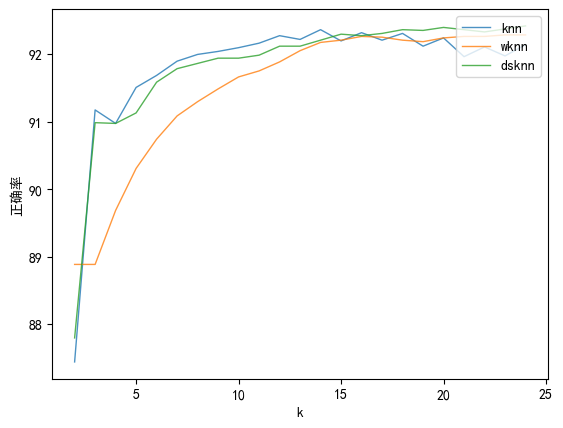

In [23]:
plt.plot(K, rates_right_knn, alpha=0.8, linewidth=1, label='knn')
plt.plot(K, rates_right_wknn, alpha=0.8, linewidth=1, label='wknn')
plt.plot(K, rates_right_dsknn, alpha=0.8, linewidth=1, label='dsknn')


plt.legend(loc="upper right")
plt.xlabel('k')
plt.ylabel('正确率')

plt.show()